In [1]:
import os
import time
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, ResNet18_Weights
from train import train_model
from data_preprocessing import prepare_dataset, BIOMARKER_COLUMNS_BINARY, CONTINUOUS_COLUMNS
from resnet50_mlp_fusion import SupCEResNet_Fusion 

In [2]:
# Main Execution
if __name__ == "__main__":
    # Configuration
    BATCH_SIZE = 32
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_CLASSES = 1  # Regression or binary classification
    NUM_FEATURES = 14  # Number of biomarkers
    IN_CHANNELS = 3  # RGB images
    NUM_EPOCHS = 25

    # Data Paths
    DATA_PATH = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES/'
    LABEL_DATA_PATH = 'OLIVES_Dataset_Labels/full_labels/Biomarker_Clinical_Data_Images.csv'

    # Initialize the model
    model = SupCEResNet_Fusion(
        name='resnet50',
        num_classes=2,  # Regression or binary classification
        num_features=NUM_FEATURES,  # Number of biomarkers
        in_channels=IN_CHANNELS  # RGB images
    ).to(DEVICE)

        # Prepare DataLoaders
    train_loader, val_loader, test_loader = prepare_dataset(
        csv_path=LABEL_DATA_PATH,
        image_root=DATA_PATH,
        batch_size=BATCH_SIZE,
        binary_cols=BIOMARKER_COLUMNS_BINARY,
        continuous_cols=CONTINUOUS_COLUMNS,
        image_mode="RGB"
    )
    
    # Define the criterion and optimizer
    criterion = nn.MSELoss()  # Use MSELoss for regression tasks
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train the model
    train_losses, val_losses, all_metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS,
        save_path='best_model.pth' #change to model path name
    )

Epoch 1/25 - Train Loss: 0.5643, Val Loss: 0.5296 - **Best Model Saved!**
MSE: 0.5296, MAE: 0.5380, R2 Score: 0.5029
Accuracy: 0.6479, Precision: 0.7405, Recall: 0.6036, F1 Score: 0.6588, ROC-AUC: 0.8674
Epoch 2/25 - Train Loss: 0.4236, Val Loss: 0.4467 - **Best Model Saved!**
MSE: 0.4467, MAE: 0.4875, R2 Score: 0.5834
Accuracy: 0.6798, Precision: 0.7271, Recall: 0.6931, F1 Score: 0.6910, ROC-AUC: 0.8990
Epoch 3/25 - Train Loss: 0.3247, Val Loss: 0.3303 - **Best Model Saved!**
MSE: 0.3303, MAE: 0.4219, R2 Score: 0.6916
Accuracy: 0.7287, Precision: 0.7366, Recall: 0.8180, F1 Score: 0.7752, ROC-AUC: 0.9210
Epoch 4/25 - Train Loss: 0.2563, Val Loss: 0.2741 - **Best Model Saved!**
MSE: 0.2741, MAE: 0.3897, R2 Score: 0.7434
Accuracy: 0.7670, Precision: 0.8021, Recall: 0.7981, F1 Score: 0.7960, ROC-AUC: 0.9376
Epoch 5/25 - Train Loss: 0.2031, Val Loss: 0.2375 - **Best Model Saved!**
MSE: 0.2375, MAE: 0.3660, R2 Score: 0.7780
Accuracy: 0.7713, Precision: 0.7694, Recall: 0.8265, F1 Score: 0.79

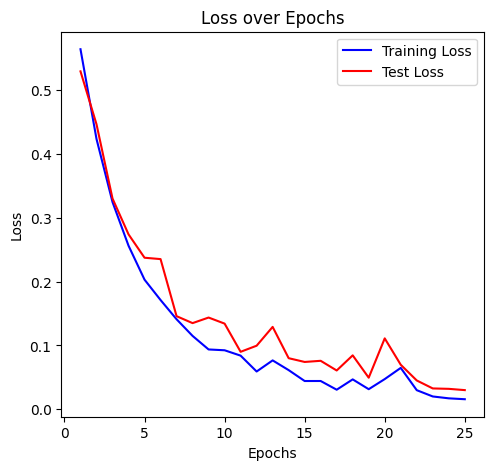

In [3]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

# Training loss + validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", color="blue")
plt.plot(epochs, val_losses, label="Test Loss", color="red")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [10]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, accuracy_score,
    mean_absolute_error, mean_squared_error,r2_score
)
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for images, biomarkers, targets in val_loader:
            images = images.to(device)
            biomarkers = biomarkers.to(device)
            targets = targets.to(device)

            outputs = model(images, biomarkers)

            # Compute loss
            loss = criterion(outputs.squeeze(), targets)

            val_loss += loss.item() * images.size(0)

            # Collect outputs and targets for metrics
            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)

    # Metrics
    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs).squeeze()

    # For regression task
    mse = mean_squared_error(all_targets, all_outputs)
    mae = mean_absolute_error(all_targets, all_outputs)
    r2 = r2_score(all_targets, all_outputs)

    # If treating as classification (binary classification)
    preds = (all_outputs > 0.5).astype(int)
    targets_binary = (all_targets > 0.5).astype(int)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        accuracy = accuracy_score(targets_binary, preds)
        precision = precision_score(targets_binary, preds, average='macro', zero_division=0)
        recall = recall_score(targets_binary, preds, average='macro', zero_division=0)
        f1 = f1_score(targets_binary, preds, average='macro', zero_division=0)
        try:
            roc_auc = roc_auc_score(targets_binary, all_outputs, average='macro')
        except ValueError:
            roc_auc = float('nan')

    metrics = {
        'val_loss': avg_val_loss,
        'mse': mse,
        'mae': mae,
        'r2_score': r2,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    return metrics

In [11]:
metrics = validation(model, test_loader, criterion, DEVICE)

print(f"MSE: {metrics['mse']:.4f}, MAE: {metrics['mae']:.4f}, R2 Score: {metrics['r2_score']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")

MSE: 0.0228, MAE: 0.1005, R2 Score: 0.9774
Accuracy: 0.9278, Precision: 0.9216, Recall: 0.9633, F1 Score: 0.9419, ROC-AUC: 0.9957
